In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.panda_mj_description import MJCF_PATH
from scripts.utils import update_actuator, ActuatorMotor

np.random.seed(0)

In [2]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "hand")

ee_body

MJCF Element: <body name="hand" pos="0 0 0.107" quat="0.92387949999999996 0 0 -0.38268340000000001">...</body>

In [3]:
# create new body
load_mass = ee_body.add("body", name="load_mass", pos="0.1 0.2 0.3")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1"
)

M = 2.0
R = 0.05
I = 2 / 5 * M * R**2

load_mass.add("inertial", mass=f"{M}", pos="0 0 0", diaginertia=f"{I} {I} {I}")

# old model
old_model = mujoco.MjModel.from_xml_path(MJCF_PATH)
old_data = mujoco.MjData(old_model)

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

""

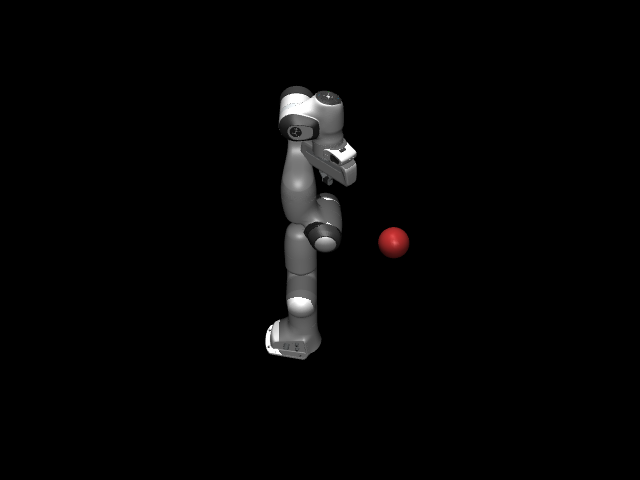

In [4]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [5]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq - 2), np.zeros(sim_model.nq - 2)
for jnt_idx in range(sim_model.nq - 2):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

kp = 20
kd = 10
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

while sim_data.time < 5.0:
    # PD controller
    target_acc = kp * (target_q - sim_data.qpos[:-2]) + kd * (
        np.zeros(sim_model.nv - 2) - sim_data.qvel[:-2]
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc[:-2] = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl[:-1] = sol[:-2]

    mujoco.mj_step(sim_model, sim_data)
    if len(frames) < sim_data.time * framerate:
        renderer.update_scene(sim_data)
        frames.append(renderer.render())

media.show_video(frames, fps=framerate)

In [6]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: 0.28 actual: 0.37
joint 1 target: 0.76 actual: 0.89
joint 2 target: 0.60 actual: 0.43
joint 3 target: -1.44 actual: -1.56
joint 4 target: -0.44 actual: -0.44
joint 5 target: 2.42 actual: 1.93
joint 6 target: -0.36 actual: -0.32
